In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Load the data
eth_data = pd.read_csv('datasets/ETH-USD (2017-2024).csv')

In [2]:
# Data Preprocessing
def preprocess_data(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Create lagged features
    data['Close_Lag_1'] = data['Close'].shift(1)
    data['Close_Lag_2'] = data['Close'].shift(2)
    data.dropna(inplace=True)

    # Scaling the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Close', 'Close_Lag_1', 'Close_Lag_2', 'Volume']].values)

    X = []
    y = []
    for i in range(60, len(scaled_data)):
        X.append(scaled_data[i-60:i, :-1])  # Last 60 days of Close, Lag_1, Lag_2
        y.append(scaled_data[i, 0])  # Next day Close

    X, y = np.array(X), np.array(y)
    return X, y, scaler

X_eth, y_eth, scaler_eth = preprocess_data(eth_data)

In [3]:
# Train-test split
def train_test_split(X, y, split_ratio=0.8):
    train_size = int(len(X) * split_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

X_train_eth, X_test_eth, y_train_eth, y_test_eth = train_test_split(X_eth, y_eth)

In [4]:
# Model Building
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model


In [5]:
# Train and evaluate the model
def train_lstm_model(X_train, y_train, X_test, y_test, scaler, epochs=50, batch_size=32):
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)
    if save_path:
        model.save(save_path)
        print(f"Model saved at: {save_path}")
    
    # Predicting and evaluating the model
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), 3))), axis=1))[:,0]
    y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 3))), axis=1))[:,0]

    mse = mean_squared_error(y_test, predictions)
    return mse, history, predictions, y_test

In [6]:
# Train and evaluate LSTM model for ETH
save_path = r"C:\Users\HP\Desktop\AI\eth_lstm_model.h5"
print("Training LSTM model for ETH...")
mse_eth, history_eth, predictions_eth, y_test_eth = train_lstm_model(X_train_eth, y_train_eth, X_test_eth, y_test_eth, scaler_eth)
print(f"LSTM Mean Squared Error for ETH: {mse_eth}")

Training LSTM model for ETH...


C:\Users\HP\Desktop\AI\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.0117 - val_loss: 0.0025
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 8.2323e-04 - val_loss: 0.0020
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 8.3119e-04 - val_loss: 0.0017
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 9.8406e-04 - val_loss: 0.0016
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 8.5751e-04 - val_loss: 0.0017
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 9.1761e-04 - val_loss: 0.0019
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 9.3007e-04 - val_loss: 0.0013
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 6.6992e-04 - val_loss: 0.0018
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━

Model saved at: C:\Users\HP\Desktop\AI\eth_lstm_model.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step
LSTM Mean Squared Error for ETH: 3221.730598116992


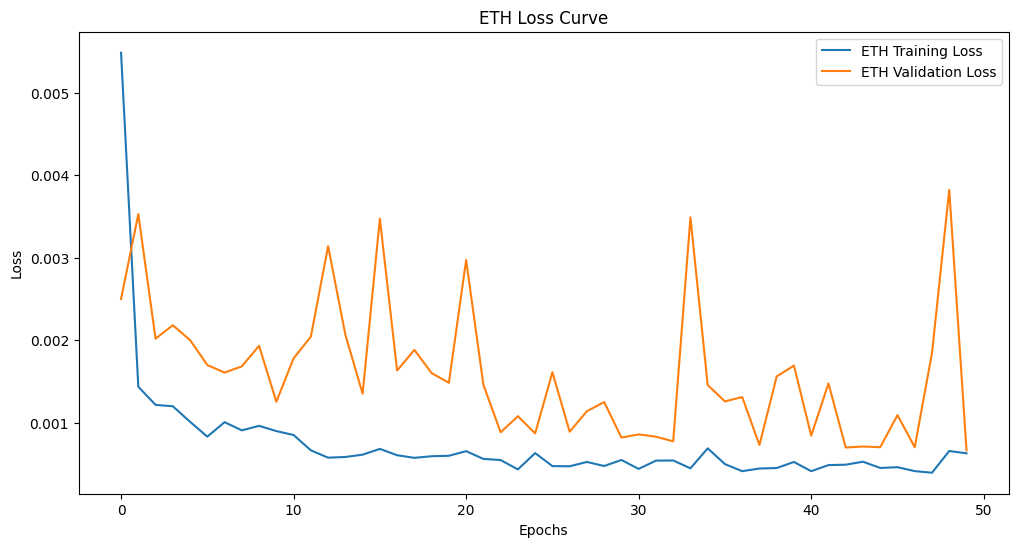

In [7]:
# Plotting the loss curves
plt.figure(figsize=(12, 6))
plt.plot(history_eth.history['loss'], label='ETH Training Loss')
plt.plot(history_eth.history['val_loss'], label='ETH Validation Loss')
plt.title('ETH Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

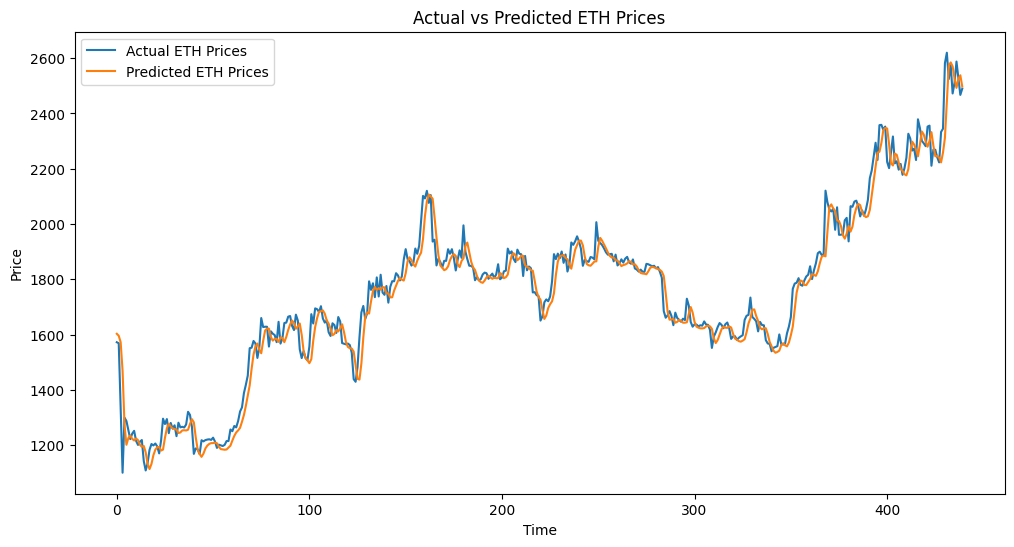

In [8]:
# Plotting the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_eth, label='Actual ETH Prices')
plt.plot(predictions_eth, label='Predicted ETH Prices')
plt.title('Actual vs Predicted ETH Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [9]:
import plotly.io as pio

# Set the renderer to 'browser' or 'notebook' as needed
pio.renderers.default = 'browser'

import plotly.graph_objects as go

# Create traces
trace1 = go.Scatter(x=list(range(len(y_test_eth))), y=y_test_eth, mode='lines', name='Actual', line=dict(color='blue'))
trace2 = go.Scatter(x=list(range(len(predictions_eth))), y=predictions_eth, mode='lines', name='Predicted', line=dict(color='red', dash='dash'))

# Create figure
fig = go.Figure(data=[trace1, trace2])

# Update layout
fig.update_layout(title='Actual vs Predicted Values', xaxis_title='Time', yaxis_title='Value')

# Show the plot
fig.show()
